In [916]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from tensorboardX import SummaryWriter
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy

In [917]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [918]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [919]:
config = {
          'batch_size': None,
          'learning_rate': 0.1,
          'max_epochs': 500,
          'momentum': 0.9,
          'initialization': {
              'type': 'uniform',
              'min': -0.5,
              'max': 0.5
          },
          'early_stopping': {
              'monitor': 'val_loss',
              'patience': 20,
              'delta': 0.0
          },
          'task': 'classification',
          'trials_train': 5,
          'trials_test': 10,
          'nesterov': False,
          'learning_rate_decay': None,
          'regularization': {
              'method': None
          },
          'activations_1': 'relu',
          'units_1': 8
         }

In [920]:
def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()


def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()


def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0))
        
    def update(self, y_pred, y_true):
        self.results += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        
        if reg_method != None:
            value = config["regularization"]["value"]
            if reg_method == "l1":
                pass
            elif reg_method == "l2":
                pass
        
        self.task = task
        self.model = nn.Sequential()
        
        units = config["units_1"]
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(1, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
                
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name == "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name == "mee"
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            self.apply(self.init_weights_uniform)
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            self.apply(self.init_weights_normal)
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
            
    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
            
    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, sefl.mean, sefl.std)
            torch.nn.init.normal_(m.bias, sefl.mean, sefl.std)
            # m.bias.data.fill_(0.01)
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.squeeze()  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            return self.metic(y_pred, y_true)
        
    
    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.squeeze() 
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            return self.loss(y_pred, y_true)
    
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'train_loss': loss, f'train_{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss


In [941]:
model = get_model(config, 17, 1)
# model = SimpleNN()

In [942]:
# sum(p.abs().sum() for p in model.model.parameters())

In [944]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [945]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [946]:
batch_size = 32


early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.001, patience=10, verbose=True, mode="min")
train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size)
validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size)
test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [948]:
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=500, log_every_n_steps=5,logger=CSVLogger(save_dir="logs/"), callbacks=[early_stop_callback])  
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=validation_loader) 


  | Name   | Type       | Params
--------------------------------------
0 | model  | Sequential | 225   
1 | metric | Accuracy   | 0     
2 | loss   | MSELoss    | 0     
--------------------------------------
225       Trainable params
0         Non-trainable params
225       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  80%|███████████▏  | 4/5 [00:00<00:00, 70.32it/s, loss=0.252, v_num=79]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 5/5 [00:00<00:00, 58.24it/s, loss=0.252, v_num=79, validation_l
                                                                                

Metric train_loss improved. New best score: 0.239


Epoch 1:  80%|▊| 4/5 [00:00<00:00, 115.47it/s, loss=0.248, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 5/5 [00:00<00:00, 59.64it/s, loss=0.248, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.236


Epoch 2:  80%|▊| 4/5 [00:00<00:00, 83.52it/s, loss=0.244, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 5/5 [00:00<00:00, 64.56it/s, loss=0.244, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.233


Epoch 3:  80%|▊| 4/5 [00:00<00:00, 91.03it/s, loss=0.239, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 3: 100%|█| 5/5 [00:00<00:00, 70.38it/s, loss=0.239, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.229


Epoch 4:  80%|▊| 4/5 [00:00<00:00, 104.27it/s, loss=0.234, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 4: 100%|█| 5/5 [00:00<00:00, 75.69it/s, loss=0.234, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.218


Epoch 5:  80%|▊| 4/5 [00:00<00:00, 89.34it/s, loss=0.223, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 5: 100%|█| 5/5 [00:00<00:00, 66.40it/s, loss=0.223, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.208


Epoch 6:  80%|▊| 4/5 [00:00<00:00, 84.43it/s, loss=0.211, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 6: 100%|█| 5/5 [00:00<00:00, 64.32it/s, loss=0.211, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.196


Epoch 7:  80%|▊| 4/5 [00:00<00:00, 102.64it/s, loss=0.197, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 7: 100%|█| 5/5 [00:00<00:00, 74.73it/s, loss=0.197, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.184


Epoch 8:  80%|▊| 4/5 [00:00<00:00, 93.28it/s, loss=0.182, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 8: 100%|█| 5/5 [00:00<00:00, 72.60it/s, loss=0.182, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.172


Epoch 9:  80%|▊| 4/5 [00:00<00:00, 96.26it/s, loss=0.167, v_num=79, validation_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 9: 100%|█| 5/5 [00:00<00:00, 71.22it/s, loss=0.167, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.163


Epoch 10:  80%|▊| 4/5 [00:00<00:00, 119.35it/s, loss=0.153, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 10: 100%|█| 5/5 [00:00<00:00, 72.78it/s, loss=0.153, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.154


Epoch 11:  80%|▊| 4/5 [00:00<00:00, 104.59it/s, loss=0.142, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 11: 100%|█| 5/5 [00:00<00:00, 75.33it/s, loss=0.142, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.146


Epoch 12:  80%|▊| 4/5 [00:00<00:00, 85.38it/s, loss=0.132, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 12: 100%|█| 5/5 [00:00<00:00, 68.74it/s, loss=0.132, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.142


Epoch 13:  80%|▊| 4/5 [00:00<00:00, 100.63it/s, loss=0.125, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 13: 100%|█| 5/5 [00:00<00:00, 79.10it/s, loss=0.125, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.141


Epoch 14:  80%|▊| 4/5 [00:00<00:00, 110.39it/s, loss=0.12, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 14: 100%|█| 5/5 [00:00<00:00, 83.67it/s, loss=0.12, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.136


Epoch 15:  80%|▊| 4/5 [00:00<00:00, 120.97it/s, loss=0.116, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 15: 100%|█| 5/5 [00:00<00:00, 72.16it/s, loss=0.116, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.134


Epoch 16:  80%|▊| 4/5 [00:00<00:00, 97.31it/s, loss=0.112, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 16: 100%|█| 5/5 [00:00<00:00, 67.05it/s, loss=0.112, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.133


Epoch 17:  80%|▊| 4/5 [00:00<00:00, 106.81it/s, loss=0.11, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 17: 100%|█| 5/5 [00:00<00:00, 76.45it/s, loss=0.11, v_num=79, validation_l
                                                                                

Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.129


Epoch 18:  80%|▊| 4/5 [00:00<00:00, 122.10it/s, loss=0.108, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 18: 100%|█| 5/5 [00:00<00:00, 75.39it/s, loss=0.108, v_num=79, validation_
Epoch 19:  80%|▊| 4/5 [00:00<00:00, 113.80it/s, loss=0.106, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 19: 100%|█| 5/5 [00:00<00:00, 82.13it/s, loss=0.106, v_num=79, validation_
Epoch 20:  80%|▊| 4/5 [00:00<00:00, 96.59it/s, loss=0.105, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 20: 100%|█| 5/5 [00:00<00:00, 63.21it/s, loss=0.105, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.124


Epoch 21:  80%|▊| 4/5 [00:00<00:00, 116.24it/s, loss=0.103, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 21: 100%|█| 5/5 [00:00<00:00, 78.07it/s, loss=0.103, v_num=79, validation_
Epoch 22:  80%|▊| 4/5 [00:00<00:00, 94.34it/s, loss=0.102, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 22: 100%|█| 5/5 [00:00<00:00, 72.46it/s, loss=0.102, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.123


Epoch 23:  80%|▊| 4/5 [00:00<00:00, 115.55it/s, loss=0.101, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 23: 100%|█| 5/5 [00:00<00:00, 78.85it/s, loss=0.101, v_num=79, validation_
Epoch 24:  80%|▊| 4/5 [00:00<00:00, 109.92it/s, loss=0.0994, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 24: 100%|█| 5/5 [00:00<00:00, 81.37it/s, loss=0.0994, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.121


Epoch 25:  80%|▊| 4/5 [00:00<00:00, 67.34it/s, loss=0.0982, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 25: 100%|█| 5/5 [00:00<00:00, 54.31it/s, loss=0.0982, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.120


Epoch 26:  80%|▊| 4/5 [00:00<00:00, 88.32it/s, loss=0.0973, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 26: 100%|█| 5/5 [00:00<00:00, 70.95it/s, loss=0.0973, v_num=79, validation
Epoch 27:  80%|▊| 4/5 [00:00<00:00, 109.65it/s, loss=0.0964, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 27: 100%|█| 5/5 [00:00<00:00, 76.20it/s, loss=0.0964, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.117


Epoch 28:  80%|▊| 4/5 [00:00<00:00, 102.46it/s, loss=0.0954, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 28: 100%|█| 5/5 [00:00<00:00, 75.65it/s, loss=0.0954, v_num=79, validation
Epoch 29:  80%|▊| 4/5 [00:00<00:00, 98.50it/s, loss=0.0946, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 29: 100%|█| 5/5 [00:00<00:00, 69.80it/s, loss=0.0946, v_num=79, validation
Epoch 30:  80%|▊| 4/5 [00:00<00:00, 88.79it/s, loss=0.0936, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 30: 100%|█| 5/5 [00:00<00:00, 65.41it/s, loss=0.0936, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.114


Epoch 31:  80%|▊| 4/5 [00:00<00:00, 77.66it/s, loss=0.0927, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 31: 100%|█| 5/5 [00:00<00:00, 62.60it/s, loss=0.0927, v_num=79, validation
Epoch 32:  80%|▊| 4/5 [00:00<00:00, 104.90it/s, loss=0.0917, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 32: 100%|█| 5/5 [00:00<00:00, 73.40it/s, loss=0.0917, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.112


Epoch 33:  80%|▊| 4/5 [00:00<00:00, 85.06it/s, loss=0.0907, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 33: 100%|█| 5/5 [00:00<00:00, 61.93it/s, loss=0.0907, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.111


Epoch 34:  80%|▊| 4/5 [00:00<00:00, 77.94it/s, loss=0.0897, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 34: 100%|█| 5/5 [00:00<00:00, 61.60it/s, loss=0.0897, v_num=79, validation
Epoch 35:  80%|▊| 4/5 [00:00<00:00, 93.85it/s, loss=0.0887, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 35: 100%|█| 5/5 [00:00<00:00, 70.15it/s, loss=0.0887, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.108


Epoch 36:  80%|▊| 4/5 [00:00<00:00, 79.21it/s, loss=0.0876, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 36: 100%|█| 5/5 [00:00<00:00, 56.89it/s, loss=0.0876, v_num=79, validation
Epoch 37:  80%|▊| 4/5 [00:00<00:00, 96.28it/s, loss=0.0865, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 37: 100%|█| 5/5 [00:00<00:00, 75.73it/s, loss=0.0865, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.105


Epoch 38:  80%|▊| 4/5 [00:00<00:00, 107.57it/s, loss=0.0855, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 38: 100%|█| 5/5 [00:00<00:00, 75.19it/s, loss=0.0855, v_num=79, validation
Epoch 39:  80%|▊| 4/5 [00:00<00:00, 120.03it/s, loss=0.0846, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 39: 100%|█| 5/5 [00:00<00:00, 82.79it/s, loss=0.0846, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.102


Epoch 40:  80%|▊| 4/5 [00:00<00:00, 68.43it/s, loss=0.0834, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 40: 100%|█| 5/5 [00:00<00:00, 53.23it/s, loss=0.0834, v_num=79, validation
Epoch 41:  80%|▊| 4/5 [00:00<00:00, 101.57it/s, loss=0.0824, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 41: 100%|█| 5/5 [00:00<00:00, 80.17it/s, loss=0.0824, v_num=79, validation
Epoch 42:  80%|▊| 4/5 [00:00<00:00, 120.28it/s, loss=0.0815, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 42: 100%|█| 5/5 [00:00<00:00, 78.43it/s, loss=0.0815, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.099


Epoch 43:  80%|▊| 4/5 [00:00<00:00, 114.79it/s, loss=0.0805, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 43: 100%|█| 5/5 [00:00<00:00, 78.45it/s, loss=0.0805, v_num=79, validation
Epoch 44:  80%|▊| 4/5 [00:00<00:00, 74.85it/s, loss=0.0795, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 44: 100%|█| 5/5 [00:00<00:00, 57.21it/s, loss=0.0795, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.097


Epoch 45:  80%|▊| 4/5 [00:00<00:00, 83.38it/s, loss=0.0785, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 45: 100%|█| 5/5 [00:00<00:00, 65.30it/s, loss=0.0785, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.096


Epoch 46:  80%|▊| 4/5 [00:00<00:00, 105.33it/s, loss=0.0775, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 46: 100%|█| 5/5 [00:00<00:00, 67.02it/s, loss=0.0775, v_num=79, validation
Epoch 47:  80%|▊| 4/5 [00:00<00:00, 120.22it/s, loss=0.0763, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 47: 100%|█| 5/5 [00:00<00:00, 64.95it/s, loss=0.0763, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.093


Epoch 48:  80%|▊| 4/5 [00:00<00:00, 98.67it/s, loss=0.0753, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 48: 100%|█| 5/5 [00:00<00:00, 68.09it/s, loss=0.0753, v_num=79, validation
Epoch 49:  80%|▊| 4/5 [00:00<00:00, 92.73it/s, loss=0.074, v_num=79, validation_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 49: 100%|█| 5/5 [00:00<00:00, 70.56it/s, loss=0.074, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.091


Epoch 50:  80%|▊| 4/5 [00:00<00:00, 136.23it/s, loss=0.073, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 50: 100%|█| 5/5 [00:00<00:00, 87.34it/s, loss=0.073, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.089


Epoch 51:  80%|▊| 4/5 [00:00<00:00, 87.68it/s, loss=0.0718, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 51: 100%|█| 5/5 [00:00<00:00, 61.31it/s, loss=0.0718, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.088


Epoch 52:  80%|▊| 4/5 [00:00<00:00, 77.83it/s, loss=0.0706, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 52: 100%|█| 5/5 [00:00<00:00, 62.65it/s, loss=0.0706, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.086


Epoch 53:  80%|▊| 4/5 [00:00<00:00, 114.08it/s, loss=0.0694, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 53: 100%|█| 5/5 [00:00<00:00, 84.34it/s, loss=0.0694, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.084


Epoch 54:  80%|▊| 4/5 [00:00<00:00, 116.91it/s, loss=0.068, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 54: 100%|█| 5/5 [00:00<00:00, 73.22it/s, loss=0.068, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.082


Epoch 55:  80%|▊| 4/5 [00:00<00:00, 87.81it/s, loss=0.0666, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 55: 100%|█| 5/5 [00:00<00:00, 64.60it/s, loss=0.0666, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.080


Epoch 56:  80%|▊| 4/5 [00:00<00:00, 93.94it/s, loss=0.0651, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 56: 100%|█| 5/5 [00:00<00:00, 73.78it/s, loss=0.0651, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.078


Epoch 57:  80%|▊| 4/5 [00:00<00:00, 122.76it/s, loss=0.0635, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 57: 100%|█| 5/5 [00:00<00:00, 74.73it/s, loss=0.0635, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.076


Epoch 58:  80%|▊| 4/5 [00:00<00:00, 123.19it/s, loss=0.0619, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 58: 100%|█| 5/5 [00:00<00:00, 74.81it/s, loss=0.0619, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.073


Epoch 59:  80%|▊| 4/5 [00:00<00:00, 90.29it/s, loss=0.0602, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 59: 100%|█| 5/5 [00:00<00:00, 70.64it/s, loss=0.0602, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.071


Epoch 60:  80%|▊| 4/5 [00:00<00:00, 117.65it/s, loss=0.0584, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 60: 100%|█| 5/5 [00:00<00:00, 77.71it/s, loss=0.0584, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069


Epoch 61:  80%|▊| 4/5 [00:00<00:00, 88.26it/s, loss=0.0566, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 61: 100%|█| 5/5 [00:00<00:00, 66.58it/s, loss=0.0566, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.067


Epoch 62:  80%|▊| 4/5 [00:00<00:00, 86.98it/s, loss=0.0548, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 62: 100%|█| 5/5 [00:00<00:00, 65.42it/s, loss=0.0548, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.064


Epoch 63:  80%|▊| 4/5 [00:00<00:00, 95.22it/s, loss=0.0531, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 63: 100%|█| 5/5 [00:00<00:00, 65.88it/s, loss=0.0531, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.063


Epoch 64:  80%|▊| 4/5 [00:00<00:00, 103.49it/s, loss=0.0516, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 64: 100%|█| 5/5 [00:00<00:00, 76.02it/s, loss=0.0516, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.060


Epoch 65:  80%|▊| 4/5 [00:00<00:00, 123.88it/s, loss=0.0503, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 65: 100%|█| 5/5 [00:00<00:00, 80.92it/s, loss=0.0503, v_num=79, validation
Epoch 66:  80%|▊| 4/5 [00:00<00:00, 79.40it/s, loss=0.0489, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 66: 100%|█| 5/5 [00:00<00:00, 55.69it/s, loss=0.0489, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.056


Epoch 67:  80%|▊| 4/5 [00:00<00:00, 86.48it/s, loss=0.0475, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 67: 100%|█| 5/5 [00:00<00:00, 66.18it/s, loss=0.0475, v_num=79, validation
Epoch 68:  80%|▊| 4/5 [00:00<00:00, 99.58it/s, loss=0.0462, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 68: 100%|█| 5/5 [00:00<00:00, 70.71it/s, loss=0.0462, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.054


Epoch 69:  80%|▊| 4/5 [00:00<00:00, 99.29it/s, loss=0.0446, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 69: 100%|█| 5/5 [00:00<00:00, 68.23it/s, loss=0.0446, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.052


Epoch 70:  80%|▊| 4/5 [00:00<00:00, 79.94it/s, loss=0.0431, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 70: 100%|█| 5/5 [00:00<00:00, 58.47it/s, loss=0.0431, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.050


Epoch 71:  80%|▊| 4/5 [00:00<00:00, 64.04it/s, loss=0.0419, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 71: 100%|█| 5/5 [00:00<00:00, 54.03it/s, loss=0.0419, v_num=79, validation
Epoch 72:  80%|▊| 4/5 [00:00<00:00, 85.26it/s, loss=0.0408, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 72: 100%|█| 5/5 [00:00<00:00, 52.52it/s, loss=0.0408, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.048


Epoch 73:  80%|▊| 4/5 [00:00<00:00, 74.72it/s, loss=0.0398, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 73: 100%|█| 5/5 [00:00<00:00, 56.99it/s, loss=0.0398, v_num=79, validation
Epoch 74:  80%|▊| 4/5 [00:00<00:00, 97.30it/s, loss=0.0389, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 74: 100%|█| 5/5 [00:00<00:00, 71.16it/s, loss=0.0389, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.046


Epoch 75:  80%|▊| 4/5 [00:00<00:00, 108.95it/s, loss=0.0379, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 75: 100%|█| 5/5 [00:00<00:00, 76.05it/s, loss=0.0379, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


Epoch 76:  80%|▊| 4/5 [00:00<00:00, 101.73it/s, loss=0.0368, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 76: 100%|█| 5/5 [00:00<00:00, 71.46it/s, loss=0.0368, v_num=79, validation
Epoch 77:  80%|▊| 4/5 [00:00<00:00, 108.88it/s, loss=0.0356, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 77: 100%|█| 5/5 [00:00<00:00, 78.72it/s, loss=0.0356, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.042


Epoch 78:  80%|▊| 4/5 [00:00<00:00, 102.27it/s, loss=0.0343, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 78: 100%|█| 5/5 [00:00<00:00, 76.76it/s, loss=0.0343, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.039


Epoch 79:  80%|▊| 4/5 [00:00<00:00, 70.15it/s, loss=0.0329, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 79: 100%|█| 5/5 [00:00<00:00, 46.34it/s, loss=0.0329, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.038


Epoch 80:  80%|▊| 4/5 [00:00<00:00, 94.56it/s, loss=0.0314, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 80: 100%|█| 5/5 [00:00<00:00, 68.99it/s, loss=0.0314, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.036


Epoch 81:  80%|▊| 4/5 [00:00<00:00, 121.70it/s, loss=0.0299, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 81: 100%|█| 5/5 [00:00<00:00, 73.44it/s, loss=0.0299, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.034


Epoch 82:  80%|▊| 4/5 [00:00<00:00, 109.52it/s, loss=0.0284, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 82: 100%|█| 5/5 [00:00<00:00, 81.91it/s, loss=0.0284, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.032


Epoch 83:  80%|▊| 4/5 [00:00<00:00, 103.96it/s, loss=0.027, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 83: 100%|█| 5/5 [00:00<00:00, 71.53it/s, loss=0.027, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.031


Epoch 84:  80%|▊| 4/5 [00:00<00:00, 104.97it/s, loss=0.0257, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 84: 100%|█| 5/5 [00:00<00:00, 76.80it/s, loss=0.0257, v_num=79, validation
Epoch 85:  80%|▊| 4/5 [00:00<00:00, 123.30it/s, loss=0.0246, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 85: 100%|█| 5/5 [00:00<00:00, 84.37it/s, loss=0.0246, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.029


Epoch 86:  80%|▊| 4/5 [00:00<00:00, 104.57it/s, loss=0.0236, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 86: 100%|█| 5/5 [00:00<00:00, 57.07it/s, loss=0.0236, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.028


Epoch 87:  80%|▊| 4/5 [00:00<00:00, 148.07it/s, loss=0.0227, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 87: 100%|█| 5/5 [00:00<00:00, 83.16it/s, loss=0.0227, v_num=79, validation
Epoch 88:  80%|▊| 4/5 [00:00<00:00, 107.10it/s, loss=0.0219, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 88: 100%|█| 5/5 [00:00<00:00, 73.19it/s, loss=0.0219, v_num=79, validation
                                                                                

Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.026


Epoch 89:  80%|▊| 4/5 [00:00<00:00, 112.90it/s, loss=0.0211, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 89: 100%|█| 5/5 [00:00<00:00, 80.03it/s, loss=0.0211, v_num=79, validation
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.025


Epoch 90:  80%|▊| 4/5 [00:00<00:00, 88.51it/s, loss=0.0199, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 90: 100%|█| 5/5 [00:00<00:00, 64.20it/s, loss=0.0199, v_num=79, validation
                                                                                

Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.021


Epoch 91:  80%|▊| 4/5 [00:00<00:00, 111.17it/s, loss=0.0175, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 91: 100%|█| 5/5 [00:00<00:00, 75.38it/s, loss=0.0175, v_num=79, validation
                                                                                

Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.013


Epoch 92:  80%|▊| 4/5 [00:00<00:00, 110.24it/s, loss=0.015, v_num=79, validation
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 92: 100%|█| 5/5 [00:00<00:00, 79.20it/s, loss=0.015, v_num=79, validation_
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.010


Epoch 93:  80%|▊| 4/5 [00:00<00:00, 129.43it/s, loss=0.0121, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 93: 100%|█| 5/5 [00:00<00:00, 85.66it/s, loss=0.0121, v_num=79, validation
                                                                                

Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.007


Epoch 94:  80%|▊| 4/5 [00:00<00:00, 123.44it/s, loss=0.00924, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 94: 100%|█| 5/5 [00:00<00:00, 84.44it/s, loss=0.00924, v_num=79, validatio
Epoch 95:  80%|▊| 4/5 [00:00<00:00, 132.81it/s, loss=0.00681, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 95: 100%|█| 5/5 [00:00<00:00, 88.66it/s, loss=0.00681, v_num=79, validatio
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.006


Epoch 96:  80%|▊| 4/5 [00:00<00:00, 80.14it/s, loss=0.00561, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 96: 100%|█| 5/5 [00:00<00:00, 58.14it/s, loss=0.00561, v_num=79, validatio
Epoch 97:  80%|▊| 4/5 [00:00<00:00, 91.26it/s, loss=0.00468, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 97: 100%|█| 5/5 [00:00<00:00, 70.91it/s, loss=0.00468, v_num=79, validatio
Epoch 98:  80%|▊| 4/5 [00:00<00:00, 127.91it/s, loss=0.00417, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 98: 100%|█| 5/5 [00:00<00:00, 90.52it/s, loss=0.00417, v_num=79, validatio
                                                                                

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004


Epoch 99:  80%|▊| 4/5 [00:00<00:00, 128.96it/s, loss=0.00387, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 99: 100%|█| 5/5 [00:00<00:00, 75.87it/s, loss=0.00387, v_num=79, validatio
Epoch 100:  80%|▊| 4/5 [00:00<00:00, 108.84it/s, loss=0.00361, v_num=79, validat
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 100: 100%|█| 5/5 [00:00<00:00, 69.48it/s, loss=0.00361, v_num=79, validati
Epoch 101:  80%|▊| 4/5 [00:00<00:00, 134.46it/s, loss=0.00339, v_num=79, validat
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 101: 100%|█| 5/5 [00:00<00:00, 90.60it/s, loss=0.00339, v_num=79, validati
Epoch 102:  80%|▊| 4/5 [00:00<00:00, 96.94it/s, loss=0.00321, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [0

Metric train_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003


Epoch 105:  80%|▊| 4/5 [00:00<00:00, 84.97it/s, loss=0.0028, v_num=79, validatio
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 105: 100%|█| 5/5 [00:00<00:00, 62.28it/s, loss=0.0028, v_num=79, validatio
Epoch 106:  80%|▊| 4/5 [00:00<00:00, 125.57it/s, loss=0.0027, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 106: 100%|█| 5/5 [00:00<00:00, 83.58it/s, loss=0.0027, v_num=79, validatio
Epoch 107:  80%|▊| 4/5 [00:00<00:00, 112.97it/s, loss=0.0026, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 107: 100%|█| 5/5 [00:00<00:00, 79.85it/s, loss=0.0026, v_num=79, validatio
Epoch 108:  80%|▊| 4/5 [00:00<00:00, 98.25it/s, loss=0.00252, v_num=79, validati
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [0

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.


Epoch 114: 100%|█| 5/5 [00:00<00:00, 48.32it/s, loss=0.00216, v_num=79, validati


In [950]:
trainer.test(model=model, dataloaders=test_loader)

Testing DataLoader 0: 100%|████████████████████| 14/14 [00:00<00:00, 147.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9791666865348816
        test_loss           0.01624359403968144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.01624359403968144, 'test_accuracy': 0.9791666865348816}]

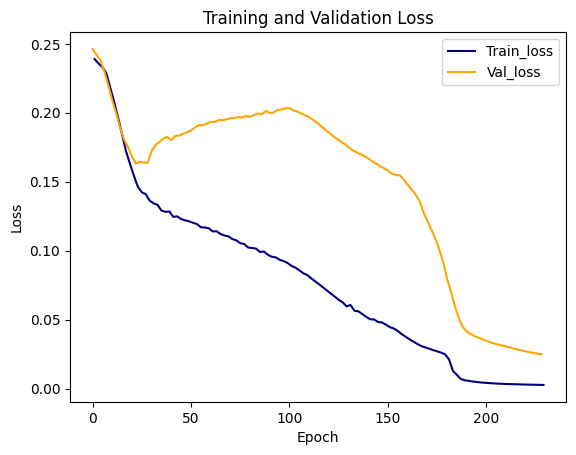

In [951]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#del metrics["step"]
metrics

tr_loss = metrics["train_loss"].dropna()
vl_loss = metrics["validation_loss"].dropna()
tr_acc = metrics["train_accuracy"].dropna()
vl_acc = metrics["validation_accuracy"].dropna()

plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")



plt.plot(tr_loss,label="Train_loss",color="navy")
plt.plot(vl_loss,label="Val_loss",color="orange")

plt.legend(loc='best')
plt.show()

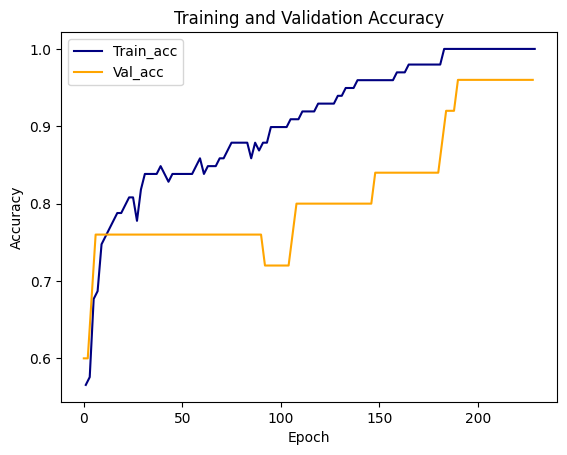

In [952]:
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")



plt.plot(tr_acc,label="Train_acc",color="navy")
plt.plot(vl_acc,label="Val_acc",color="orange")

plt.legend(loc='best')
plt.show()


In [953]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="auto"
        )
        
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size):
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=5,logger=CSVLogger(save_dir="logs/"),
                         callbacks=[early_stop_callback])  
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

    history = {
        "history": { }
    }
        
    history["history"]["train_loss"] = metrics["train_loss"].to_list()
    history["history"]["val_loss"] = metrics["val_loss"].to_list()
    history["history"][f"train_{metric}"] = metrics[f"train_{metric}"].to_list()
    history["history"][f"val_{metric}"] = metrics[f"val_{metric}"].to_list()
    
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        print(config)

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    # model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# Monk 1

In [954]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [955]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


In [956]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}
Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}



  0%|                                                     | 0/5 [00:00<?, ?it/s]GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | model  | Sequential | 225   
1 | metric | Accuracy   | 0     
2 | loss   | MSELoss    | 0     
--------------------------------------
225       Trainable params
0         Non-trainable params
225       Total params
0.001     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

  0%|                                                     | 0/5 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [133]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [181]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [183]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)
